The Goal of this Notebook is to predict Future Sales given historical data (daily granularity). This is a part of the kaggle competition "Predict Future Sales": https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data Where more information about the problem, dataset and other solutions can be found.

For my own usage, this is a part of the Capstone Project as part of the Udacity Machine Learning Engineer Nanodegree program and so am running this on AWS Sagemaker, with a conda_pytorch_36 shell.

Author: Steven Vuong. <br>
Most recent update: 25/05/2020

In [1]:
# mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
# cd to dir
% cd '../gdrive/My Drive/self_teach/udacity_ml_eng_nanodegree'

/gdrive/My Drive/self_teach/udacity_ml_eng_nanodegree


In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder

# Visualisation Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Styling Preferences
%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Before we begin, Thanks to the following notebooks who I gained some ideas from in feature engineering/visualisations (and took code snippets from). I would suggest having a look at their notebooks and work also, and if you like it, give them a thumbs up on Kaggle to support their work :)):
-  https://www.kaggle.com/dlarionov/feature-engineering-xgboost
-  https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data
-  https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda

In [0]:
# Load in dataset (cast float64 -> float32 and int32 -> int16 to save memory)
items = pd.read_csv('./data/competition_files/items.csv', 
                    dtype={'item_name': 'str', 'item_id': 'int16', 'item_category_id': 'int16'}
                   )
shops = pd.read_csv('./data/competition_files/shops.csv',
                    dtype={'shop_name': 'str', 'shop_id': 'int16'}
                   )
categories = pd.read_csv('./data/competition_files/item_categories.csv', 
                         dtype={'item_category_name': 'str', 'item_category_id': 'int16'}
                        )
train = pd.read_csv('./data/competition_files/sales_train.csv', 
                    dtype={
                        'date': 'str', 
                        'date_block_num': 'int16', 
                        'shop_id': 'int16', 
                        'item_id': 'int16', 
                        'item_price': 'float32', 
                        'item_cnt_day': 'int16'}
                   )
# set index to ID to avoid dropping it later
test  = pd.read_csv('./data/competition_files/test.csv', 
                    dtype={'ID': 'int16', 'shop_id': 'int16', 'item_id': 'int16'}
                   ).set_index('ID')

In [0]:
# Cast train date from string to datetime data type
train.date = train.date.str.replace(".", "/")
train.date = pd.to_datetime(train.date)

Join the different data sets; merge onto train df

In [0]:
train = train.join(
    items, on='item_id', rsuffix='_').join(
    shops, on='shop_id', rsuffix='_').join(
    categories, on='item_category_id', rsuffix='_').drop(
    ['item_id_', 'shop_id_', 'item_category_id_'], axis=1
)

Probe the train data, it appears that there are no nan data, or missing data, which is quite good.

In [7]:
print("----------Top-5- Record----------")
print(train.head(5))
print("-----------Information-----------")
print(train.info())
print("-----------Data Types-----------")
print(train.dtypes)
print("----------Missing value-----------")
print(train.isnull().sum())
print("----------Null value-----------")
print(train.isna().sum())
print("----------Shape of Data----------")
print("Number of rows = {}, Number of columns = {}".format(len(train), len(train.columns)))
print("----------Data Description----------")
print(train.describe())

----------Top-5- Record----------
        date  ...                   item_category_name
0 2013-02-01  ...                       Кино - Blu-Ray
1 2013-03-01  ...                       Музыка - Винил
2 2013-05-01  ...                       Музыка - Винил
3 2013-06-01  ...                       Музыка - Винил
4 2013-01-15  ...  Музыка - CD фирменного производства

[5 rows x 10 columns]
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int16         
 2   shop_id             int16         
 3   item_id             int16         
 4   item_price          float32       
 5   item_cnt_day        int16         
 6   item_name           object        
 7   item_category_id    int16         
 8   shop_name           object        
 9   item_category_name  o

In [8]:
# look at time period of data
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


Data is from 1st January 2013 to 10th Decemer 2015, as we expect

So it turns out that a lot of data in the training set for columns "shop_id" and "item_id" does not appear in the test set. This could be perhaps because the item is no longer on sale as time goes on or shops have closed down or moved addresses. As we want to predict data in the test set, we will focus on only using "shop_id" and "item_id" that appears in the test set. 

These rows may contain information so could be worth keeping as an extra column (commented out) indicating whether or not the train_id or shop_id is in the test set. Unfortunately however, we are tight on memory and so will not be doing that in this notebook.

To make this more future proof where the "shop_id" and "item_id" might change over time (in a production environment, let's say), one may want to consider a data pipeline to constantly train and update our model with the latest information regarding shop_id and item_id's etc.. 

In [0]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

# Only shops that exist in test set.
corrlate_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
correlate_train = corrlate_train[corrlate_train['item_id'].isin(test_item_ids)]

In [10]:
print('Initial data set size :', train.shape[0])
print('Data set size after matching crossovers between train and test:', correlate_train.shape[0])

Initial data set size : 2935849
Data set size after matching crossovers between train and test: 1224439


In [0]:
# Make separate column to indicate whether or not the train_id and shop_id is in test
# train['is_in_test'] = train.index.isin(correlate_train.index)
# train.head()

In [12]:
# Reduce train set to just match ones in test set regarding train_id and shop_id
train = correlate_train
len(train)

1224439

It appears we have 5 duplicated rows, let's look into these

In [13]:
print('Number of duplicates:', len(train[train.duplicated()]))

Number of duplicates: 5


The Itetm ID's are all the same, as well as the price for a number of them; other columns such as date, date_block_num look different. So this appears not to be a mistake. As there are only 5 duplicated rows, we will leave these in for now and deal with these later.

In [14]:
train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
1435367,2014-02-23,13,50,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Тюмень ТЦ ""Гудвин""",Игры - XBOX 360
1496766,2014-03-23,14,21,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Москва МТРЦ ""Афи Молл""",Игры - XBOX 360
1671873,2014-01-05,16,50,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Тюмень ТЦ ""Гудвин""",Игры - XBOX 360
1866340,2014-12-07,18,25,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Москва ТРК ""Атриум""",Игры - XBOX 360
2198566,2014-12-31,23,42,21619,499.00,1,ЧЕЛОВЕК ДОЖДЯ (BD),37,"СПб ТК ""Невский Центр""",Кино - Blu-Ray


Plot the train data; look for outliers. It seems like there are a few with item price > 100000 and with item count per day > 1000. We will remove these from our training set.

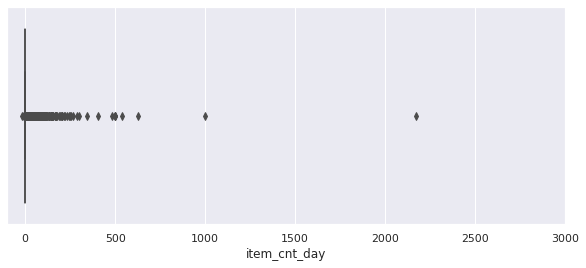

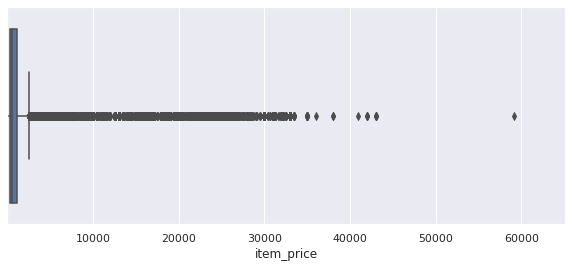

In [15]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [0]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1000]

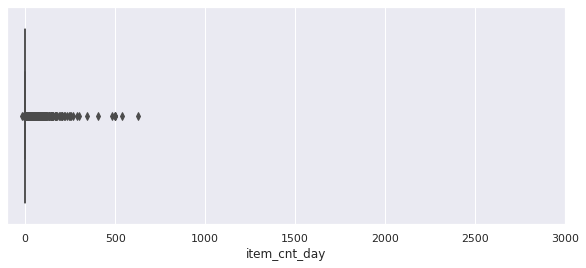

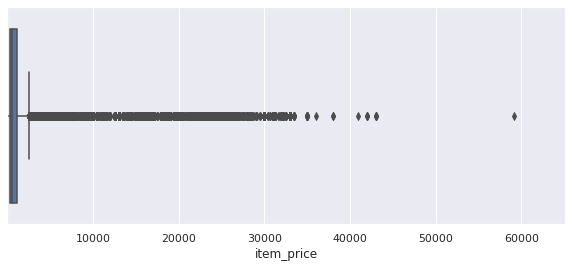

In [17]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

plt.show()

Looking better after having removed outliers.

Fill any item_price < 0 with the median item price median.

In [18]:
# Calculate the item price median
median = train.item_price.median()
print("Item Price Median = {}".format(median))
train.loc[train.item_price<0, 'item_price'] = median

Item Price Median = 549.0


In [19]:
# Double there are no item price rows < 0
train.loc[train.item_price<0, 'item_price'] 

Series([], Name: item_price, dtype: float32)

Count number of rows with item_cnt_day < 0; seems too many to be anomalous and could be an important feature. We will leave this in our dataset.

In [20]:
len(train.loc[train.item_cnt_day<0, 'item_cnt_day'])

2941

Some shops are duplicates of each other (according to name), we will fix these in our train and test set.

In [0]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Process "Shop_name" column -> shop name begins with city name.

In [0]:
# Fix erroneous shop name title
train.loc[train.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [23]:
# Create a column for city
train['city'] = train['shop_name'].str.split(' ').map(lambda x: x[0])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва


In [0]:
# Fix a city name (typo)
train.loc[train.city == '!Якутск', 'city'] = 'Якутск'

In [25]:
# Encode the city name into a code column
train['city_code'] = LabelEncoder().fit_transform(train['city'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city,city_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль,27
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12


Each category name contains type and subtype in its name. Treat this similarly as to how we treated shop name, split into separate columns and encode into labels (one hot encoding).

In [26]:
# Create separate column with split category name
train['split_category_name'] = train['item_category_name'].str.split('-')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city,city_code,split_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль,27,"[Кино , Blu, Ray]"
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]"
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]"
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]"
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]"


In [27]:
# Make column for category type and encode
train['item_category_type'] = train['split_category_name'].map(lambda x : x[0].strip())
train['item_category_type_code'] = LabelEncoder().fit_transform(train['item_category_type'])

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city,city_code,split_category_name,item_category_type,item_category_type_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль,27,"[Кино , Blu, Ray]",Кино,7
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9


In [28]:
# Do the same for subtype, make column wiht name if nan then set to the type
train['item_category_subtype'] = train['split_category_name'].map(
    lambda x: x[1].strip() if len(x) > 1 else x[0].strip()
)
# Make separate encoded column
train['item_category_subtype_code'] = LabelEncoder().fit_transform(train['item_category_subtype'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city,city_code,split_category_name,item_category_type,item_category_type_code,item_category_subtype,item_category_subtype_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль,27,"[Кино , Blu, Ray]",Кино,7,Blu,1
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9,CD локального производства,2
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9,CD локального производства,2
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9,CD локального производства,2
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9,CD локального производства,2


We can now drop the following columns, having captured and encoded the necessary information from them:
-  shop_name
-  item_category_name
-  split_category_name
-  item_category_type
-  item_category_subtype

In [29]:
train = train.drop(['shop_name', 
                    'item_category_name', 
                    'split_category_name', 
                    'item_category_type', 
                    'item_category_subtype',
                   ], axis = 1)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,city,city_code,item_category_type_code,item_category_subtype_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,Ярославль,27,7,1
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2


Looking at item name, perhaps we can reduce the number of unique types, as there are too many at the moment which our model might struggle with, so we will try to categorise some of these by just taking the first part of an item name and encoding this.

In [30]:
print("Number of unique Item names = {}".format(len(train.item_name.unique())))

Number of unique Item names = 4716


In [31]:
# Split item name, extracting first word of the string
train['item_name_split'] = train['item_name'].str.split(' ').map(lambda x : x[0].strip())
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,city,city_code,item_category_type_code,item_category_subtype_code,item_name_split
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,Ярославль,27,7,1,ЯВЛЕНИЕ
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL


In [32]:
print("Number of unique Item First Words = {}".format(len(train['item_name_split'].unique())))

Number of unique Item First Words = 1590


This seems substantial enough, so we will encode this once again into another column.

In [33]:
train['item_name_code'] = LabelEncoder().fit_transform(train['item_name_split'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,city,city_code,item_category_type_code,item_category_subtype_code,item_name_split,item_name_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,Ярославль,27,7,1,ЯВЛЕНИЕ,1587
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL,145
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL,145
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL,145
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL,145


And now we can drop the following columns:
-  item_name
-  item_name_split
-  city (forgot to drop in last round)

In [34]:
train = train.drop(['item_name', 
                    'item_name_split',
                    'city'
                   ], axis = 1)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_code,item_category_type_code,item_category_subtype_code,item_name_code
0,2013-02-01,0,59,22154,999.00,1,37,27,7,1,1587
10,2013-03-01,0,25,2574,399.00,2,55,12,9,2,145
11,2013-05-01,0,25,2574,399.00,1,55,12,9,2,145
12,2013-07-01,0,25,2574,399.00,1,55,12,9,2,145
13,2013-08-01,0,25,2574,399.00,2,55,12,9,2,145


So the features above are the ones so far deemed as useful and thus are kept on. We will group by month into dataframe; then by the other columns and then aggregate the item price and count, determining the mean average and sum per month.

In [35]:
print(len(train))

1224437


In [36]:
# Group by month (date_block_num)
# Could do more complex, just want something very basic to aggregate
train_by_month = train.sort_values('date').groupby([
                                                    'date_block_num', 
                                                    'item_category_type_code',
                                                    'item_category_subtype_code',
                                                    'item_name_code',
                                                    'city_code',
                                                    'shop_id', 
                                                    'item_category_id',
                                                    'item_id',
    # Keep simple; will just use the above columns 
], as_index=False)
train_by_month.size()

date_block_num  item_category_type_code  item_category_subtype_code  item_name_code  city_code  shop_id  item_category_id  item_id
0               0                        9                           365             0          2        2                 5572       7
                                                                                     1          3        2                 5572       3
                                                                                     2          4        2                 5572       3
                                                                                     4          6        2                 5572       7
                                                                                                7        2                 5572       7
                                                                                                                                     ..
33              13                       47          

In [37]:
# everything is organised by date block num, great!
train_by_month.head().head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_code,item_category_type_code,item_category_subtype_code,item_name_code
32043,2013-01-01,0,2,12134,299.00,1,30,0,5,41,888
107345,2013-01-01,0,38,32,349.00,1,40,15,7,4,1
107421,2013-01-01,0,37,22088,79.00,4,83,14,13,47,1579
107443,2013-01-01,0,37,22087,79.00,2,83,14,13,47,1579
107472,2013-01-01,0,38,4885,1499.00,1,23,15,3,15,332


In [38]:
train_by_month.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_code,item_category_type_code,item_category_subtype_code,item_name_code
32043,2013-01-01,0,2,12134,299.00,1,30,0,5,41,888
107345,2013-01-01,0,38,32,349.00,1,40,15,7,4,1
107421,2013-01-01,0,37,22088,79.00,4,83,14,13,47,1579
107443,2013-01-01,0,37,22087,79.00,2,83,14,13,47,1579
107472,2013-01-01,0,38,4885,1499.00,1,23,15,3,15,332
...,...,...,...,...,...,...,...,...,...,...,...
2887817,2015-12-10,33,46,22102,1250.00,1,42,19,8,18,1580
2887766,2015-12-10,33,46,20801,7499.00,1,72,19,10,45,1509
2887761,2015-12-10,33,46,20629,2399.00,1,72,19,10,45,1509
2897403,2015-12-10,33,56,5232,1199.00,1,23,25,3,15,349


In [0]:
# Aggregate item price and item count
train_by_month = train_by_month.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

In [40]:
train_by_month.head()

date_block_num item_category_type_code  ... item_cnt_day      
                                          ...         mean count
0              0                       0  ...         1.29     7
1              0                       0  ...         1.00     3
2              0                       0  ...         1.00     3
3              0                       0  ...         1.14     7
4              0                       0  ...         1.14     7

[5 rows x 13 columns]

In [41]:
# See how many rows we now have
len(train_by_month)

600158

In [42]:
# Sanity check on number of months
train_by_month.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [43]:
# Rename columns
train_by_month.columns = ['date_block_num', 
                         'item_category_type_code',
                         'item_category_subtype_code',
                         'item_name_code',
                         'city_code',
                         'shop_id', 
                         'item_category_id',
                         'item_id',
                         'sum_item_price',
                         'mean_item_price',
                         'sum_item_count',
                         'mean_item_count',
                         'transactions']
train_by_month.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions
0,0,0,9,365,0,2,2,5572,10730.00,1532.86,9,1.29,7
1,0,0,9,365,1,3,2,5572,4770.00,1590.00,3,1.00,3
2,0,0,9,365,2,4,2,5572,4570.00,1523.33,3,1.00,3
3,0,0,9,365,4,6,2,5572,11130.00,1590.00,8,1.14,7
4,0,0,9,365,4,7,2,5572,11030.00,1575.71,8,1.14,7


As we have to apply predictions to the test set, we must ensure all possible combinations of "shop_id" and "item_id" are covered. 

To do this, we will loop through all possible combinations in our test set and append to an empty dataframe. Then we will merge that empty dataframe to our main dataframe and fill in missing na values with 0.

In [0]:
# Get all unique shop id's and item id's
shop_ids = test['shop_id'].unique()
item_ids = test['item_id'].unique()
# Initialise empty df
empty_df = []
# Loop through months and append to dataframe
for i in range(34):
    for item in item_ids:
        for shop in shop_ids:
          empty_df.append([i, shop, item])
# Turn into dataframe
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [45]:
# Merge monthly train set with the complete set (missing records will be filled with 0).
train_by_month = pd.merge(train_by_month, empty_df, on=['date_block_num','shop_id','item_id'], how='outer')
len(train_by_month)

7282800

In [46]:
# Double check we have no na records
train_by_month.isna().sum()

date_block_num                      0
item_category_type_code       6682642
item_category_subtype_code    6682642
item_name_code                6682642
city_code                     6682642
shop_id                             0
item_category_id              6682642
item_id                             0
sum_item_price                6682642
mean_item_price               6682642
sum_item_count                6682642
mean_item_count               6682642
transactions                  6682642
dtype: int64

The fact we have so many na is quiet concerning. Perhaps many more item_id or shop_id values were added in the most recent month (test data) that is not included in the training data. Whilst there may be better ways of dealing with this, we will be fill the missing na records with 0 and progress.

In [0]:
# Filll missing records with na
train_by_month.fillna(0, inplace=True)

In [48]:
train_by_month.isna().sum()

date_block_num                0
item_category_type_code       0
item_category_subtype_code    0
item_name_code                0
city_code                     0
shop_id                       0
item_category_id              0
item_id                       0
sum_item_price                0
mean_item_price               0
sum_item_count                0
mean_item_count               0
transactions                  0
dtype: int64

In [49]:
train_by_month.describe()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions
count,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00
mean,16.50,0.56,1.34,58.02,1.17,31.67,3.50,11019.40,173.25,75.01,0.22,0.09,0.17
std,9.81,2.04,6.26,235.35,4.40,17.53,12.74,6252.63,2087.32,509.42,3.20,0.46,0.87
min,0.00,0.00,0.00,0.00,0.00,2.00,0.00,30.00,0.00,0.00,-4.00,-2.00,0.00
25%,8.00,0.00,0.00,0.00,0.00,16.00,0.00,5381.50,0.00,0.00,0.00,0.00,0.00
50%,16.50,0.00,0.00,0.00,0.00,34.50,0.00,11203.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,0.00,0.00,0.00,0.00,47.00,0.00,16071.50,0.00,0.00,0.00,0.00,0.00
max,33.00,13.00,47.00,1589.00,27.00,59.00,83.00,22167.00,515573.59,42990.00,1305.00,500.00,31.00


In this first feature-engineering notebook, we have inspected the data, removed outliers and identified features (as well as engineer others) we would like to use for further feature engineering to train our model with. 

As our feature-engineering steps are quite numerous, we will split it up into separate notebooks, more to come in part-2.

In [0]:
# Save this as a csv 
train_by_month.to_csv('./data/output/processed_data_pt1.csv', index=False, header=True)